# Plot data from Rigol DS1054Z scope

## Import the libraries

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 8]
plt.rcParams['figure.dpi'] = 300
import numpy as np
import math
import pandas as pd
import csv
from datetime import datetime 
import glob

## Import local libraries

In [2]:
from appvib import ClSigFeatures, ClSigCompUneven

## Define plot mode. 
Interactive mode is helpful for visuallizing the program execution

In [3]:
#%matplotlib widget

## Define function to read header values

In [4]:
def get_header(str_filename_in):
    """
    
    Pulls in the header information from the scope files
    
    Parameters
    ----------
    str_filename_in : string
        full file name to read
        
    Returns
    -------
    list : header values
    
    """
    
    # Read the CSV headers
    print(str_filename_in)
    file_handle = open(str_filename_in)
    csv_reader = csv.reader(file_handle)
    lst_header = next(csv_reader)
    print(lst_header)
    file_handle.close()

    return lst_header

## Define files to read

A helpful discussion on getting .csv files into Panda:
https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

Choose files by entering them in a list. Clumsy, but I need to test specific cases

In [5]:
lst_filenames = ['test_001_000.csv', 'test_001_001.csv', 'test_001_002.csv']

Or all files with a given extension in the current director

In [6]:
#lst_filenames = []
#for file in glob.glob("*.csv"):
#    lst_filenames.append(file)

## Read in the first data set and visualize the results

In [7]:
help(ClSigFeatures.b_read_data_as_df)

Help on function b_read_data_as_df in module appvib:

b_read_data_as_df(self, str_filename=None)
    Read the entire file in as a pandas dataframe
    
    Parameters
    ----------
    str_filename : string
        Filename, including .csv extension,  to read. If None then filename stored
        in the class is used
    
    Returns
    --------
    lst_data : list
            pandas dataframe : dataframe with all data from the file
            numpy array, datetime : vector with date and timestamps
            numpy array, double : vector with signal sampling rates
            numpy array, double : vector with delta time interval for each signal
            list, string :  list with engineering units descriptions
            list, string : machine name



### Plot a data collection

Setup the storage arrays

In [8]:
dt_timestamp_base = datetime.now()
np_d_time_ch1 = np.array([])
np_d_time_ch2 = np.array([])
np_d_nx = np.array([])
np_dt_timestamp_ch1 = np.array([])
np_dt_timestamp_ch2 = np.array([])

Loop through the files

In [9]:
for idx, str_filename in enumerate(lst_filenames):
    class_file = ClSigFeatures([1.,2.,3.], 1.)
    lst_file = class_file.b_read_data_as_df(str_filename)

    df1 = lst_file[0]
    np_dt_timestamp_ch1 = np.append(np_dt_timestamp_ch1, lst_file[1][0])
    np_dt_timestamp_ch2 = np.append(np_dt_timestamp_ch2, lst_file[1][1])
    d_seconds_ch1 = (np_dt_timestamp_ch1[idx] - np_dt_timestamp_ch1[0]).total_seconds()
    d_seconds_ch2 = (np_dt_timestamp_ch2[idx] - np_dt_timestamp_ch2[0]).total_seconds()
    np_d_fs = lst_file[2]
    lst_str_eu = lst_file[4]
    lst_str_machine_name = lst_file[5]
    
    # Validate input
    assert( len(df1.CH1) == 1200) , 'Failed to load the correct number of samples'

    # Instantiate a new class and populate it with the file contents
    class1 = ClSigFeatures(df1.CH1, np_d_fs[0], dt_timestamp=np_dt_timestamp_ch1[idx], str_machine_name=lst_str_machine_name[1])
    
    # Add the second signal and plot it
    class1.idx_add_sig(df1.CH2, d_fs=np_d_fs[1], str_point_name='CH2', dt_timestamp=np_dt_timestamp_ch2[idx], 
                       str_machine_name=lst_str_machine_name[2])    
    class1.ylim_tb(ylim_tb_in=[-1.0, 1.0], idx=1)
    
    np_d_eventtimes = class1.np_d_est_triggers(np_d_sig=class1.np_d_sig, i_direction=0, d_threshold=0.125)
    
    # 1X extraction
    np_d_nx = np.append(np_d_nx, class1.calc_nx(np_d_sig=class1.get_np_d_sig(idx=1), np_d_eventtimes=class1.np_d_eventtimes(),
                                          b_verbose=False))
    
    # Time series
    np_d_time_ch1 = np.append(np_d_time_ch1, class1.np_d_eventtimes()+d_seconds_ch1)
    np_d_time_ch2 = np.append(np_d_time_ch2, class1.np_d_eventtimes(idx=1)+d_seconds_ch2)

### Plot amplitude and phase over time (APHT plot)

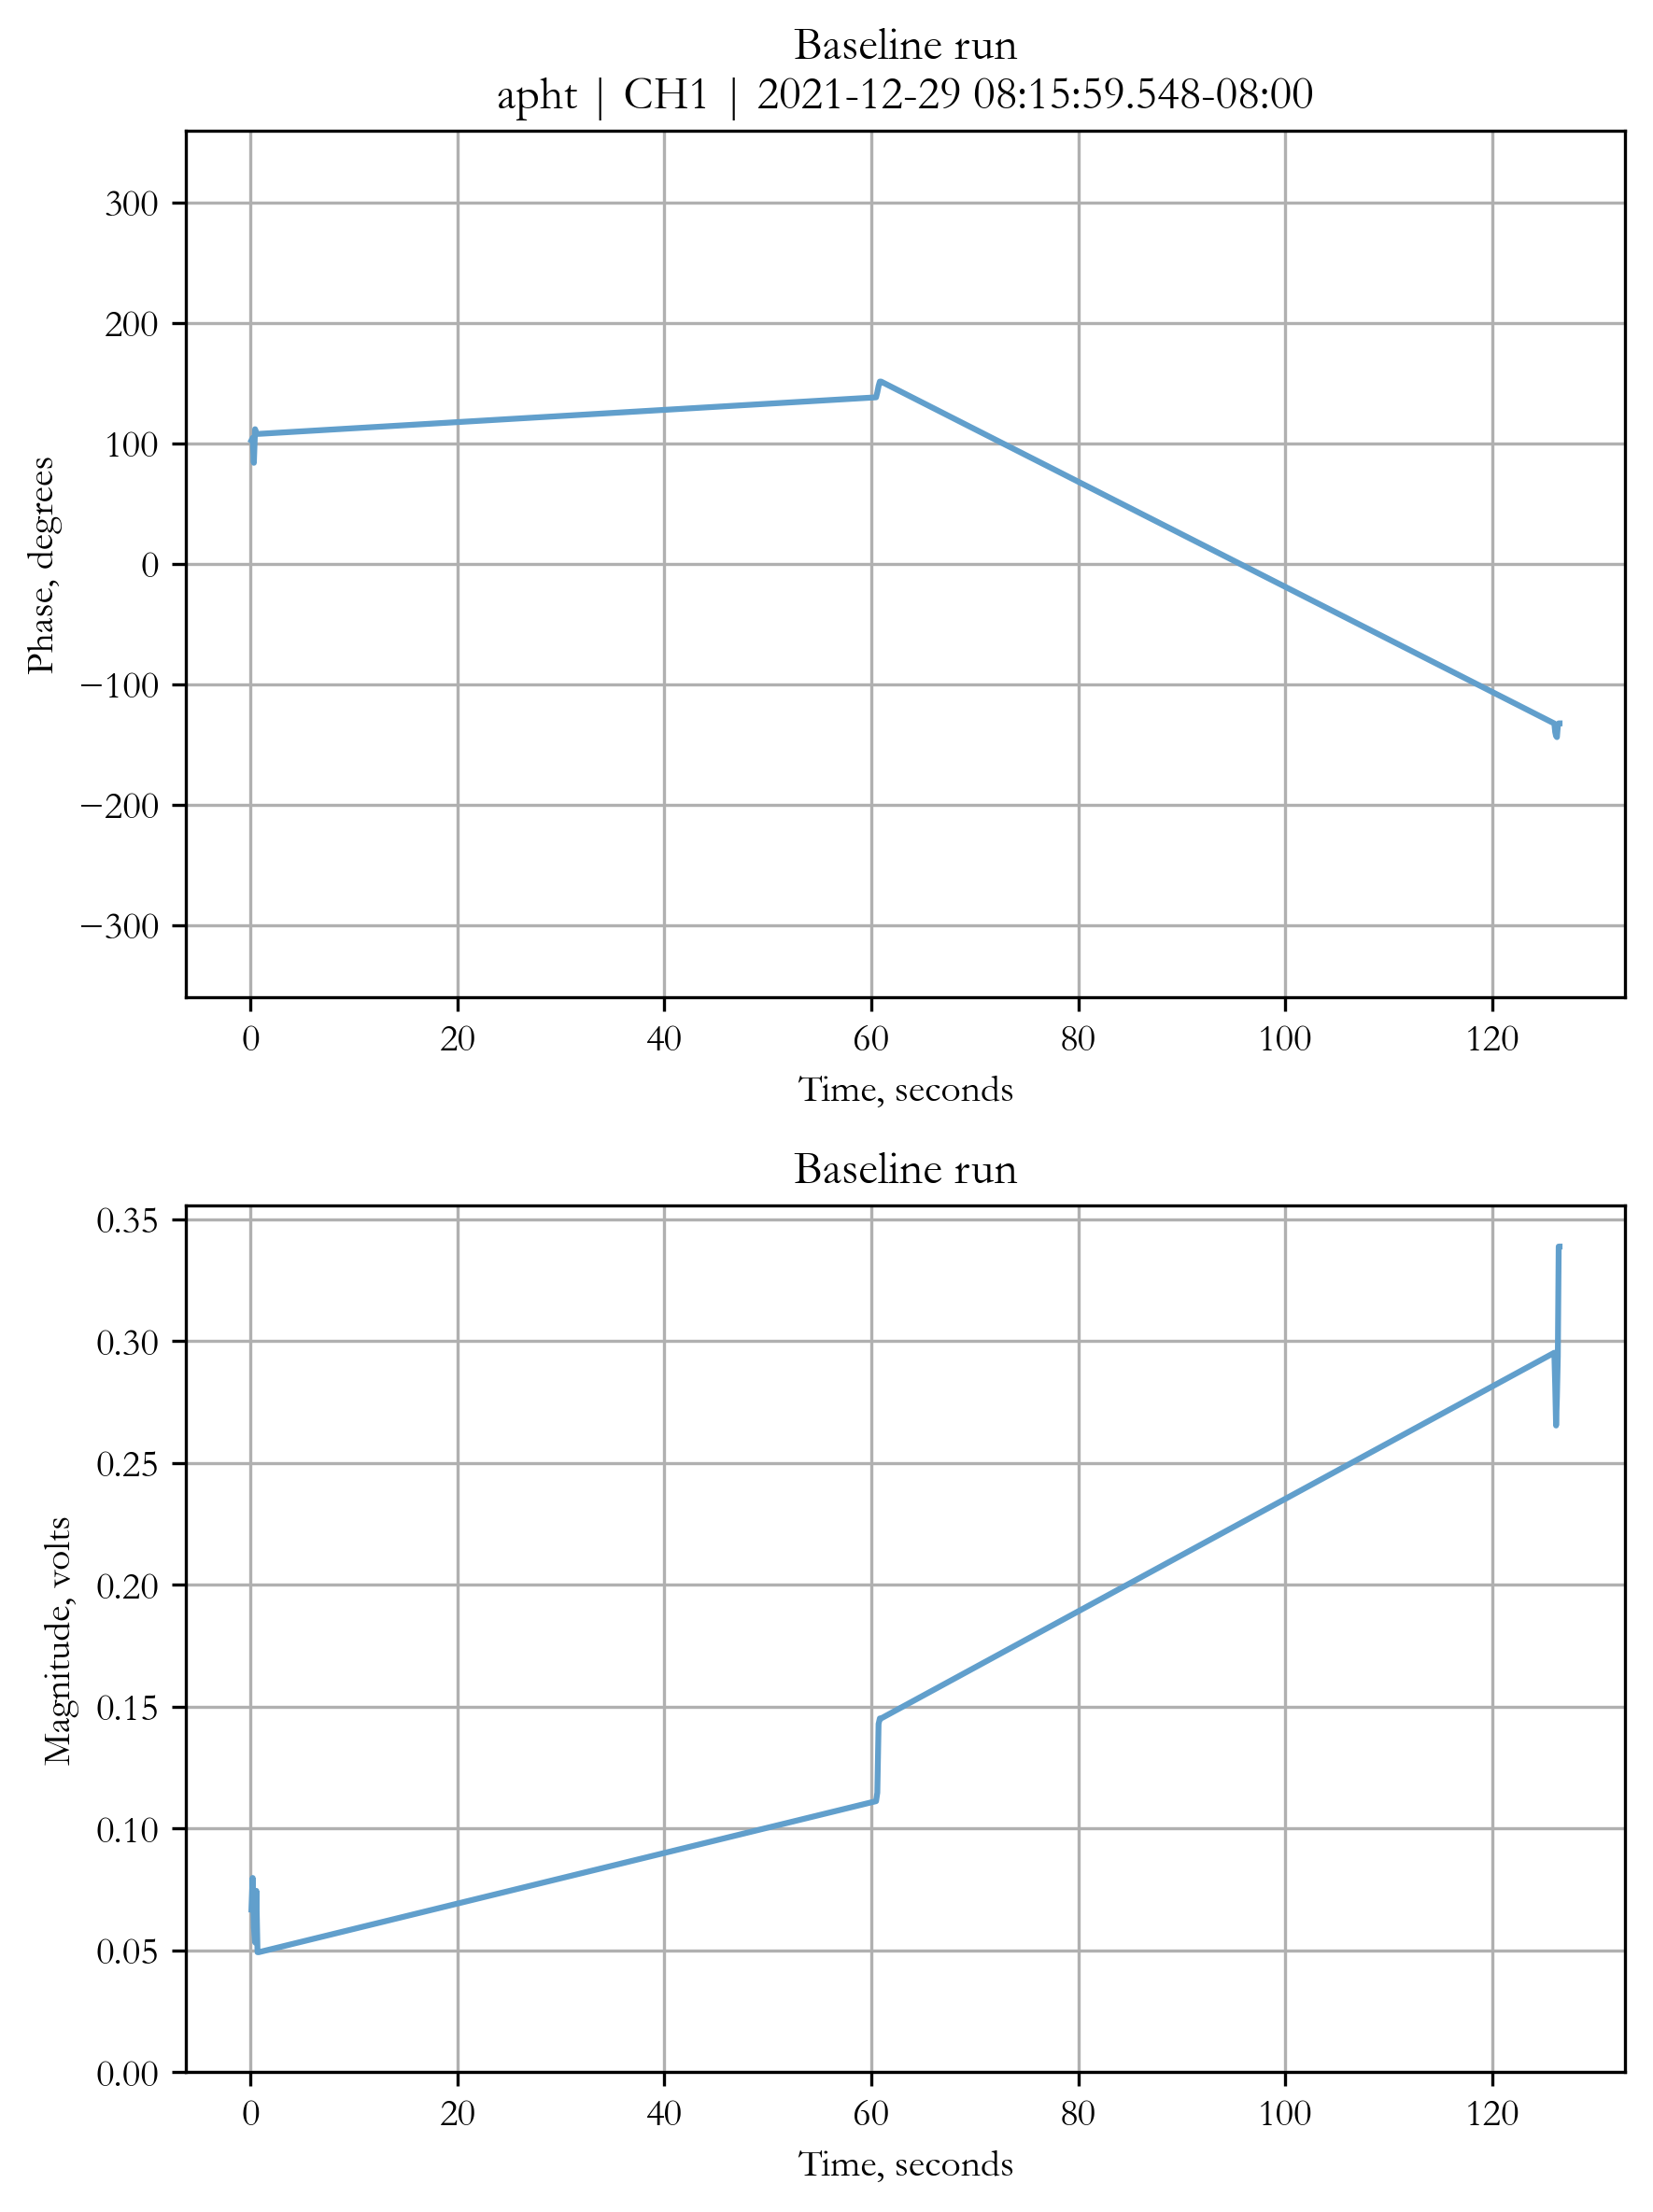

In [10]:
class_nx = ClSigCompUneven(np_d_nx, np_d_time_ch1, str_eu='volts', str_point_name='CH1', dt_timestamp=dt_timestamp_base)
class_nx.str_plot_desc = 'Baseline run'
lst_apht = class_nx.plt_apht()

### Plot 1X vectors in polar format

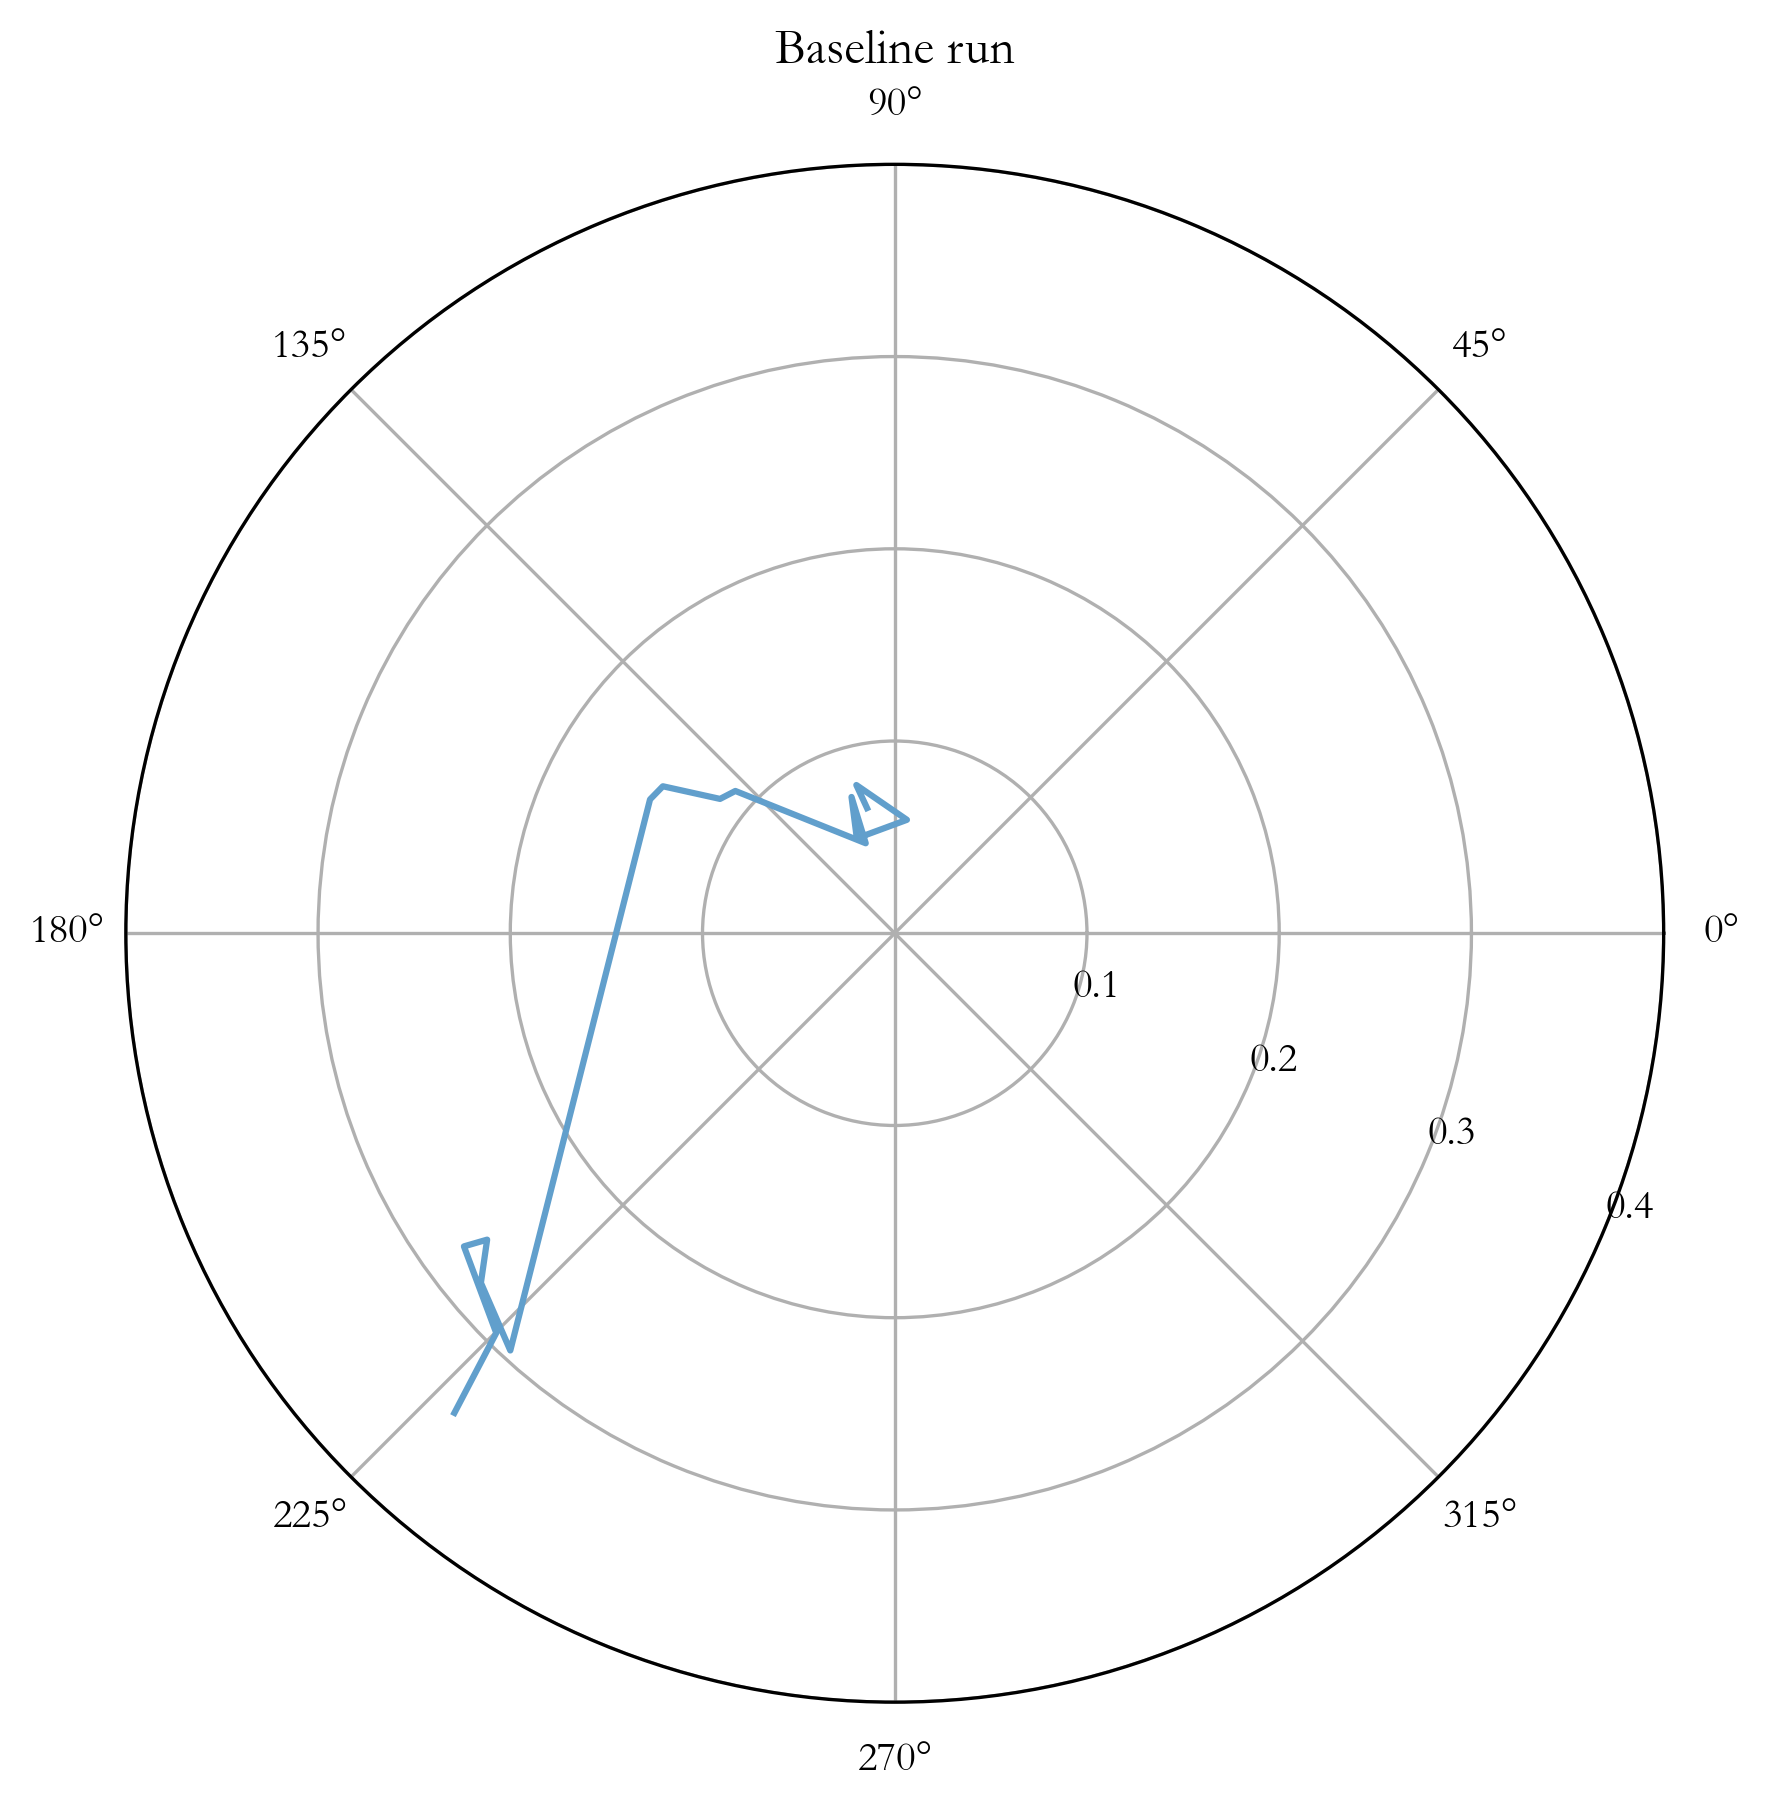

In [11]:
lst_polor = class_nx.plt_polar()

### Timebase with complete sparklines

Pull in the middle waveform

In [12]:
class_file = ClSigFeatures([1.,2.,3.], 1.)
lst_file = class_file.b_read_data_as_df(lst_filenames[1])

Retrieve signal features

In [13]:
df1 = lst_file[0]
np_dt_timestamp_sig_ch1 = lst_file[1][0]
np_dt_timestamp_sig_ch2 = lst_file[1][1]
np_d_fs = lst_file[2]
lst_str_eu = lst_file[4]
lst_str_machine_name = lst_file[5]

Instantiate the class

In [14]:
class_complete = ClSigFeatures(df1.CH1, np_d_fs[0], dt_timestamp=np_dt_timestamp_ch1[0], 
                               str_machine_name=lst_str_machine_name[1])

Setup the custom sparklines to override the signal-specific defaults

In [19]:
np_d_time_ch1

array([1.07754901e-01, 2.25514589e-01, 3.42310042e-01, 4.60151792e-01,
       5.77884125e-01, 6.94631708e-01, 8.12446104e-01, 6.04685230e+01,
       6.05901046e+01, 6.07109186e+01, 6.08323248e+01, 6.09531169e+01,
       1.26010386e+02, 1.26094825e+02, 1.26179829e+02, 1.26264849e+02,
       1.26349703e+02, 1.26434165e+02, 1.26519065e+02])

In [21]:
np_dt_timestamp_ch1[0]

datetime.datetime(2021, 12, 9, 5, 36, 10, 782000, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600)))

In [ ]:
d_pkpk_mean = np.mean(np.abs(class_complete.))
str_point_spark = ClassPlotSupport.get_plot_sparkline_desc(lst_fmt[1],
                                                           d_rms_avg,
                                                           self.str_eu,
                                                           'rms')

In [15]:
str_spark_point = '1X Vector Amplitude'
np_sparklines = np.array([ClSigCompUneven(np.abs(np_d_nx)*10.0, np_d_time_ch1,
                                          str_eu='GOATS', str_point_name=str_spark_point,
                                          str_machine_name=lst_str_machine_name[1],
                                          dt_timestamp=np_dt_timestamp_ch1[0])])
class_complete.np_sparklines_update(np_sparklines, idx=0)
class_complete.dt_timestamp_mark_update(np_dt_timestamp_ch1[1], idx=0)

In [17]:
plt.rcParams['figure.figsize'] = [6, 4]
class_complete.ylim_tb(ylim_tb_in=[-0.5, 0.5])

[-0.5, 0.5]

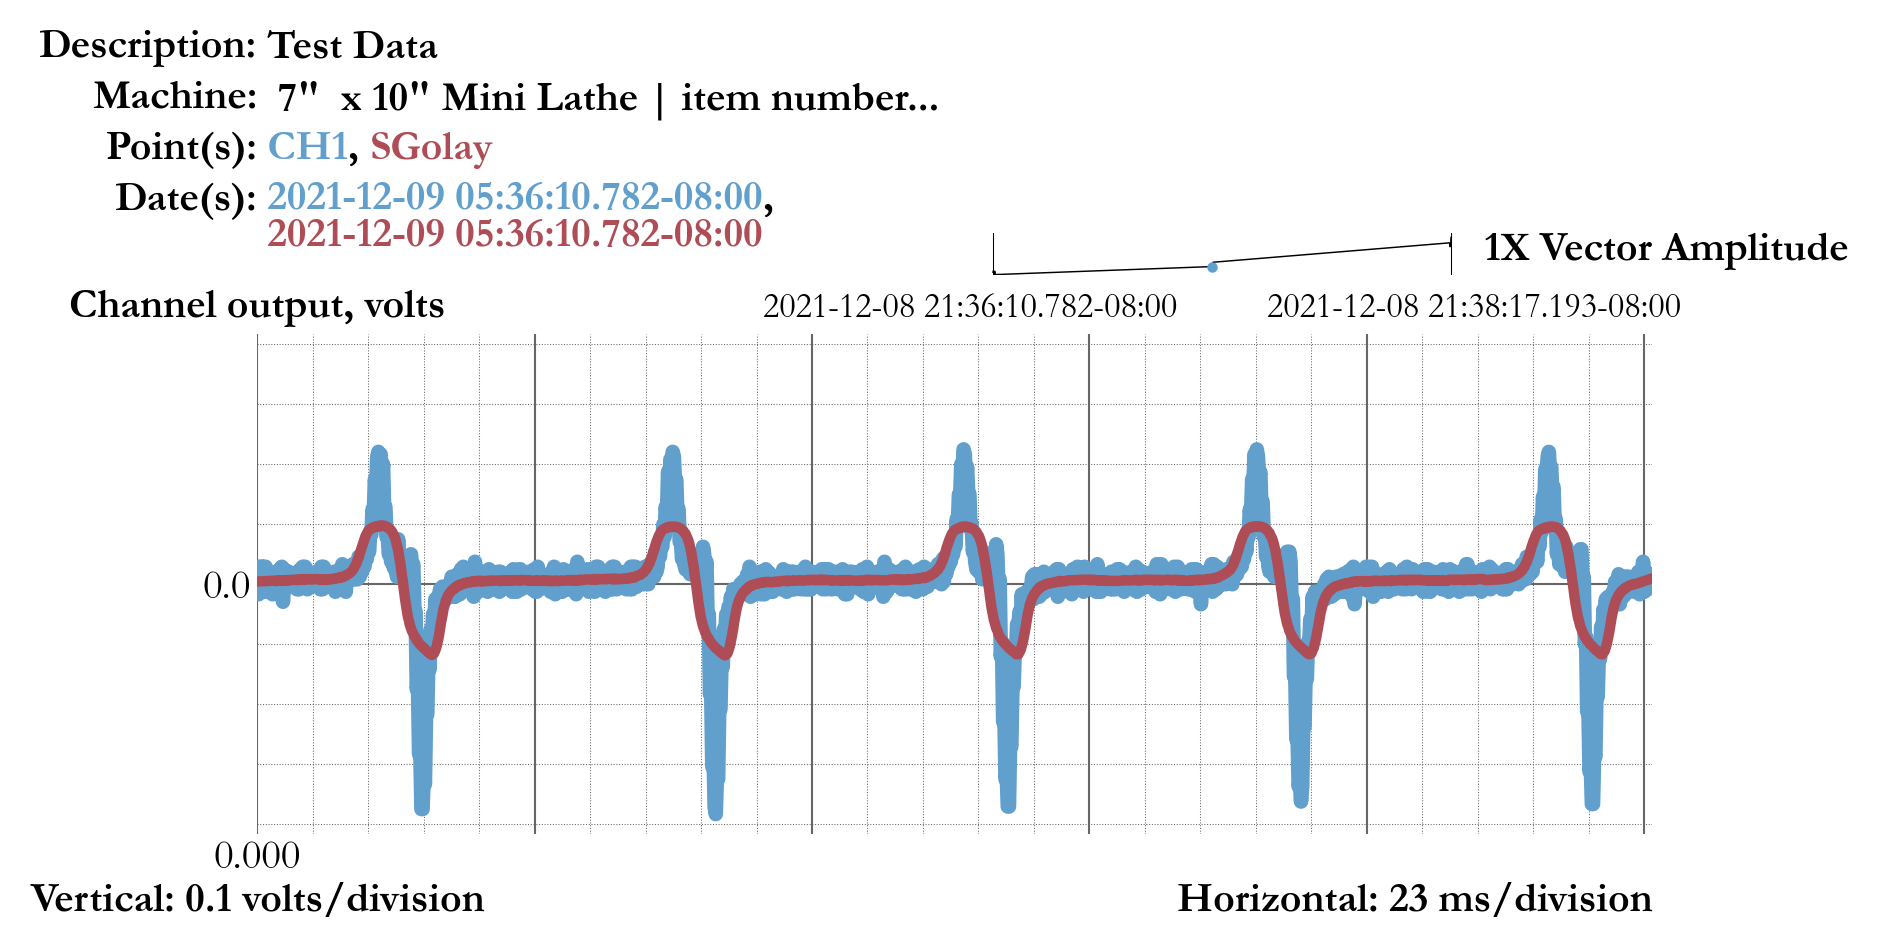

In [18]:
lst_plot_sig = class_complete.plt_sigs(b_plot_sg=True)
lst_plot_sig.savefig('TestPlot3.pdf')